# MODELOS DE RIESGO CON PYTHON

# Semana 4: Actividad Clustering KMeans()
## Estrategias de Cobranza

### Integrantes:
#### Nombres / Nombres

## OBJETIVO

La gestión de cobranzas es uno de los ciclos más relevantes en el ciclo de crédito, pero es uno de los procesos con más limitación en la asignación de recursos, por lo que es necesario identificar los segmentos o grupos de clientes con más características de recuperabilidad y así definir una estrategia de contactabilidad. La base de datos consiste en información a nivel clientes con distintas fuentes de información y/o variables del proceso de cobranzas (se incluye diccionario de las variables). Uno de los usos de los algoritmos de clustering, en particular, KMeans() es segmentación de clientes. Para hacer esto, se realizan los siguientes pasos.
1. Aplicar KMeans() variando 𝑘 entre 1 y 100 y buscar el mejor 𝑘. Use n_init=1.
2. Compare la heurísitica vista en clases de K-means v/s C-means..
3. Determine los perfiles de los grupos.
4. Proponer estrategias de cobranzas en base a los segmentos encontrados

## LIBRERÍAS Y FUNCIONES

### *Instalación de librerías*

In [4]:
#pip install pandas
#pip install numpy
#pip install scikit-learn
#pip install matplotlib
#pip install gap-stat==2.0.2
#pip install openpyxl
#pip install seaborn
#pip install statsmodels
#pip install scikit-fuzzy
#pip install plotnine
#pip install ydata_profiling

### *Carga de librerías*

In [1]:
# Manejo de datos
import numpy as np  
import pandas as pd 
from itertools import combinations

# Visualización
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt  # Creación de gráficos
import seaborn as sns

# Machine Learning (Clustering)

from sklearn.cluster import KMeans 
import skfuzzy as fuzzy
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler  # Normalización de datos
from sklearn.metrics import silhouette_score  # Evaluación de calidad del clustering
from scipy.stats import spearmanr
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Análisis avanzado de clusters
from gap_statistic import OptimalK  # Selección del número óptimo de clusters (Gap Statistic)

# Sistema de archivos
import os 
import openpyxl

### *Carga de funciones auxiliares*

In [2]:
#1. Funciones exploratorias
def informacion_general(df, umbral_categoricas):
    """
    Función para obtener información general de un DataFrame:
    - Número de filas y columnas.
    - Clasificación de variables en listas según su tipo (numéricas, categóricas, fechas, etc.).
    - Identifica variables numéricas con un número limitado de valores como categóricas especiales.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        umbral_categoricas (int): Número máximo de valores únicos para considerar una variable numérica como categórica especial.

    Returns:
        dict: Diccionario con las listas de variables numéricas, categóricas, fechas, categóricas especiales, y otras.
    """
    # Número de filas y columnas
    print(f"El DataFrame tiene {df.shape[0]} filas y {df.shape[1]} columnas.\n")
    
    # Inicializar listas para clasificar las variables
    variables_categoricas = []
    variables_numericas = []
    variables_fecha = []
    variables_otros = []
    variables_categoricas_especiales = []
    
    # Clasificación de las variables según su tipo
    for col in df.columns:
        unique_values = df[col].nunique()  # Contar valores únicos
        if pd.api.types.is_numeric_dtype(df[col]):
            # Verificar si la variable numérica tiene pocos valores únicos
            if unique_values <= umbral_categoricas:
                variables_categoricas_especiales.append(col)
            else:
                variables_numericas.append(col)
        elif pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:
            variables_categoricas.append(col)
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            variables_fecha.append(col)
        else:
            variables_otros.append(col)
    
    # Imprimir las listas
    print(f"Variables numéricas: {variables_numericas}\n")
    print(f"Variables categóricas: {variables_categoricas}\n")
    print(f"Variables de tipo fecha: {variables_fecha}\n")
    print(f"Variables categóricas especiales (<= {umbral_categoricas} valores únicos): {variables_categoricas_especiales}\n")
    print(f"Variables de otros tipos: {variables_otros}\n")
    
    # Retornar las listas en un diccionario
    return {
        "numericas": variables_numericas,
        "categoricas": variables_categoricas,
        "fechas": variables_fecha,
        "categoricas_especiales": variables_categoricas_especiales,
        "otros": variables_otros
    }


#2. Función para ver la calidad de los datos
def calidad_datos(df, listas_variables, iqr_factor = 5):
    """
    Función para analizar la calidad de los datos:
    - Identifica valores nulos por tipo de variable (numéricas, categóricas, fechas, etc.).
    - Detecta duplicados en el DataFrame completo.
    - Detecta posibles errores.
    - Encuentra outliers usando el método IQR (Interquartile Range) e incluye explicaciones.

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        listas_variables (dict): Diccionario con listas de variables clasificadas (numéricas, categóricas, etc.).
        iqr_factor (float): Factor para determinar outliers usando el rango intercuartílico.

    Returns:
        dict: Resumen de la calidad de los datos, incluyendo valores nulos, duplicados, posibles errores y outliers.
    """
    resumen = {}

    # Valores nulos
    print("Análisis de valores nulos:")
    nulos = df.isnull().sum()
    total_filas = len(df)
    porcentaje_nulos = (nulos / total_filas) * 100

    print("\nValores nulos por tipo de variable:")
    for tipo, lista in listas_variables.items():
        if lista:
            nulos_tipo = nulos[lista]
            porcentaje_tipo = porcentaje_nulos[lista]
            print(f"\nTipo: {tipo}")
            print(pd.DataFrame({"Valores Nulos": nulos_tipo, "% Nulos": porcentaje_tipo}).sort_values("% Nulos", ascending=False))
    
    resumen["valores_nulos"] = nulos

    # Duplicados
    print("\nAnálisis de duplicados:")
    duplicados = df.duplicated().sum()
    print(f"Registros duplicados: {duplicados} ({(duplicados / total_filas) * 100:.2f}%)")
    resumen["duplicados"] = duplicados

    # Posibles errores
    print("\nAnálisis de posibles errores:")
    errores = {}

    # Errores en variables categóricas (categorías mal etiquetadas)
    if "categoricas" in listas_variables:
        for col in listas_variables["categoricas"]:
            valores_unicos = df[col].unique()
            print(f"Columna categórica: {col} - Valores únicos: {valores_unicos}")
            errores[col] = {"valores_unicos": valores_unicos}

    # Errores en variables numéricas (valores fuera de rango)
    if "numericas" in listas_variables:
        for col in listas_variables["numericas"]:
            minimo = df[col].min()
            maximo = df[col].max()
            print(f"Columna numérica: {col} - Rango: [{minimo}, {maximo}]")
            errores[col] = {"min": minimo, "max": maximo}
    
    resumen["posibles_errores"] = errores

    # Detección de outliers con IQR
    print("\nAnálisis de outliers (Método IQR):")
    outliers = {}
    if "numericas" in listas_variables:
        for col in listas_variables["numericas"]:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - iqr_factor * IQR
            limite_superior = Q3 + iqr_factor * IQR

            # Identificar índices de outliers
            outliers_indices = df[(df[col] < limite_inferior) | (df[col] > limite_superior)].index
            outliers_values = df.loc[outliers_indices, col]
            if not outliers_values.empty:  # Solo imprimir si hay outliers
                outliers[col] = {
                    "outliers": len(outliers_indices),
                    "indices": outliers_indices.tolist(),
                    "limites": (limite_inferior, limite_superior),
                    "min_outlier": outliers_values.min(),
                    "max_outlier": outliers_values.max(),
                }

                # Mensaje explicativo
                print(
                    f"Columna {col}: Se detectaron {len(outliers_indices)} valores fuera de los límites definidos "
                    f"por los cuantiles.\n"
                    f"- Límite inferior: {limite_inferior}\n"
                    f"- Límite superior: {limite_superior}\n"
                    f"Estos valores se consideran outliers porque están fuera del rango intercuartílico "
                    f"({iqr_factor} veces el IQR).\n"
                    f"- El mínimo registro considerado como outlier es: {outliers[col]['min_outlier']}\n"
                    f"- El máximo registro considerado como outlier es: {outliers[col]['max_outlier']}\n"
                )
    
    resumen["outliers"] = outliers

    return resumen

def relaciones_entre_variables(df, listas_variables, max_categorias=10):
    """
    Analiza las relaciones entre variables en un DataFrame.
    - Relaciones lineales: Correlación de Pearson entre variables numéricas.
    - Relaciones no lineales: Correlación de Spearman entre variables numéricas.
    - Relaciones con variables categóricas: Proporción de varianza explicada (Eta Squared).

    Args:
        df (pd.DataFrame): El DataFrame a analizar.
        listas_variables (dict): Diccionario con listas de variables clasificadas (numéricas, categóricas, etc.).
        max_categorias (int): Número máximo de categorías para analizar relaciones categóricas.

    Returns:
        dict: Diccionario con los resultados de las relaciones encontradas.
    """
    resultados = {
        "relaciones_lineales": [],
        "relaciones_no_lineales": [],
        "relaciones_categoricas": []
    }

    # 1. Relaciones Lineales (Correlación de Pearson)
    if "numericas" in listas_variables and len(listas_variables["numericas"]) > 1:
        correlaciones = df[listas_variables["numericas"]].corr()

        # Mapa de calor
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Mapa de Calor de Correlaciones (Pearson)")
        plt.show()

        # Top 3 relaciones lineales más fuertes
        corr_pairs = (
            correlaciones.abs()
            .unstack()
            .drop_duplicates()
            .sort_values(ascending=False)
        )
        top_3_corr = corr_pairs[corr_pairs < 1].head(3)  # Excluir autocorrelaciones
        for idx, value in top_3_corr.items():
            resultados["relaciones_lineales"].append({"variables": idx, "correlacion": value})

    # 2. Relaciones No Lineales (Correlación de Spearman)
    if "numericas" in listas_variables and len(listas_variables["numericas"]) > 1:
        spearman_results = []
        for var1, var2 in combinations(listas_variables["numericas"], 2):
            corr, _ = spearmanr(df[var1], df[var2])
            spearman_results.append((var1, var2, abs(corr)))

        # Ordenar por la relación más fuerte
        spearman_results.sort(key=lambda x: -x[2])
        top_3_spearman = spearman_results[:3]
        for var1, var2, corr in top_3_spearman:
            resultados["relaciones_no_lineales"].append({"variables": (var1, var2), "correlacion": corr})

    # 3. Relaciones con Variables Categóricas
    if "categoricas" in listas_variables and "numericas" in listas_variables:
        cat_num_relations = []
        for cat in listas_variables["categoricas"]:
            # Filtrar variables categóricas con un número razonable de categorías
            if df[cat].nunique() <= max_categorias:
                for num in listas_variables["numericas"]:
                    modelo = smf.ols(f"{num} ~ C({cat})", data=df).fit()
                    anova_tabla = sm.stats.anova_lm(modelo, typ=2)
                    eta_squared = anova_tabla['sum_sq'][0] / anova_tabla['sum_sq'].sum()
                    cat_num_relations.append((cat, num, eta_squared))

        # Top 3 relaciones categóricas-numéricas más significativas
        cat_num_relations.sort(key=lambda x: -x[2])
        top_3_categoricas = cat_num_relations[:3]
        for cat, num, eta in top_3_categoricas:
            resultados["relaciones_categoricas"].append({"categoria": cat, "numerica": num, "eta_squared": eta})

    return resultados

3. #Elimina variables correlacionadas

def eliminar_correlaciones(df, limite, method):
    """
    Elimina columnas de un DataFrame que están altamente correlacionadas.

    Args:
        dataset (pd.DataFrame): El dataset con las variables.
        limite (float): El umbral de correlación. Variables con una correlación
                           mayor a este valor serán eliminadas.
        method (str): Método de correlación ('pearson', 'spearman', 'kendall').

    Returns:
        pd.DataFrame: Un nuevo DataFrame con las variables seleccionadas.
        list: Lista de columnas eliminadas.
    """
    # Seleccionar solo las columnas numéricas
    dataset = df.select_dtypes(include=[np.number])

    # Calcula la matriz de correlación con el método especificado
    corr_matrix = dataset.corr(method=method).abs()
    
    # Selecciona solo la mitad superior de la matriz para evitar duplicados
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Encuentra las columnas con una correlación mayor al umbral
    columnas_a_eliminar = [
        column for column in upper_tri.columns if any(upper_tri[column] > limite)
    ]
    
    # Crea un nuevo DataFrame sin las columnas seleccionadas
    df_red = df.drop(columns=columnas_a_eliminar, axis=1)
    
    return df_red, columnas_a_eliminar

#4. Elimina outliers utilizando el método del Rango Intercuartilico (IQR)

def eliminar_outliers_iqr(dataframe, columnas, iqr_factor):
    """
    Elimina outliers de un DataFrame utilizando el método del Rango Intercuartil (IQR).
    
    Parámetros:
    - dataframe: DataFrame de pandas del cual se quieren eliminar outliers.
    - columnas: Lista de nombres de columnas en las que se aplicará la eliminación de outliers.
    
    Retorna:
    - DataFrame sin los outliers.
    """
    df_sin_outliers = dataframe.copy()
    
    for columna in columnas:
        Q1 = df_sin_outliers[columna].quantile(0.25)  # Primer cuartil (25%)
        Q3 = df_sin_outliers[columna].quantile(0.75)  # Tercer cuartil (75%)
        IQR = Q3 - Q1  # Rango intercuartil
        
        # Límites para detectar outliers
        limite_inferior = Q1 - iqr_factor * IQR
        limite_superior = Q3 + iqr_factor * IQR
        
        # Filtrar datos dentro del rango permitido
        df_sin_outliers = df_sin_outliers[
            (df_sin_outliers[columna] >= limite_inferior) & 
            (df_sin_outliers[columna] <= limite_superior)
        ]
    
    return df_sin_outliers



## PREPROCESAMIENTO Y RECODIFICACIÓN DE DATOS

### *Carga tabla de datos*

In [3]:
print(os.getcwd())  # Devuelve el directorio actual de trabajo
path = os.getcwd()
print(path)
archivos = os.listdir(path)  
print("Archivos y carpetas:", archivos)

c:\Users\Pau\OneDrive\Cursos\Modelos de riesgo de Crédito con Aplicaciones en R y Python - 2024\Sesion 4\Evaluacion 1
c:\Users\Pau\OneDrive\Cursos\Modelos de riesgo de Crédito con Aplicaciones en R y Python - 2024\Sesion 4\Evaluacion 1
Archivos y carpetas: ['caso segmentacion.xlsx', 'Data Mining with Python.pdf', 'Evaluacion-1.ipynb', 'Evaluacion_I_Bladi.ipynb', 'Evaluacion_I_Fdo.ipynb']


In [4]:
#Ver el nombre de las hojas del Excel
excel_file = pd.ExcelFile(os.path.join(path, 'caso segmentacion.xlsx'))
print("Hojas disponibles en el archivo:")
print(excel_file.sheet_names)

Hojas disponibles en el archivo:
['dictionary', 'data']


In [5]:
#Hoja de Diccionario
diccionario_datos = pd.read_excel(os.path.join(path, 'caso segmentacion.xlsx'), sheet_name = "dictionary")

#Hoja de Datos
datos_cobranza=pd.read_excel(os.path.join(path, 'caso segmentacion.xlsx') , sheet_name='data', header=0)

### *Atributos disponibles para modelamiento*

A continuación se detallan las distintas variables con las que se trabajó para el desarrollo del análisis. 
Esta lista contempla sólo las variables originales del dataset. La creación de nuevas variables será detallada más adelante.

In [6]:
diccionario_datos 

,Features,Definition,Additional Note
0,KEY_784,bureau score / bajo 450 son exclusiones por a...,NaN
1,KEY_858,Orion key,Internal risk score using BNS customers' depos...
2,KEY_857,Bureau WORST_DELQ_L12M,NaN
3,KEY_781,worst delinquency in last 12 months in the fin...,NaN
4,KEY_909,Number of times 2 CPD L12M (All RV/LN/MG accou...,NaN
5,KEY_417,worst delinquent L12M - all products,NaN
6,KEY_808,Number of trades with 30 days+ delinquency in ...,NaN
7,KEY_924,hedy score / bajo 100 son exclusiones por agr...,Internal risk score to evaluting if we should ...
8,KEY_802,Number of Trades with 60 days+ delinquency in ...,NaN
9,KEY_908,Number of times 1 CPD L12M (All RV/LN/MG accou...,NaN


In [7]:
# Eliminar espacios al inicio y final de los nombres de las columnas
datos_cobranza.columns = datos_cobranza.columns.str.strip()

# Opcional: Reemplazar espacios internos con guiones bajos
datos_cobranza.columns = datos_cobranza.columns.str.replace(' ', '_')

### *Análisis exploratorio de datos*

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(datos_cobranza, title="Reporte de Análisis Exploratorio", explorative=True)
profile.to_notebook_iframe()  # Para mostrar el informe en un Jupyter Notebook


In [ ]:
#Si no tiene más de 10 registros distintos se considerará categorica (esto aplica para las var númericas).
#listas_variables = informacion_general(datos_cobranza, umbral_categoricas=10)

Posterior a la revisión descriptiva de los datos, se realiza:
- Una reclasificación de variables según su tipo (numéricas, categóricas, fechas, etc.)
- Se identifican variables numéricas con un número limitado de valores y se consideran como categóricas especiales.

In [8]:
#Si no tiene más de 5 registros distintos se considerará categorica (esto aplica para las var númericas).
listas_variables = informacion_general(datos_cobranza, umbral_categoricas=5)

El DataFrame tiene 6564 filas y 31 columnas.

Variables numéricas: ['Delinquent_balance', 'cyc_dlq_43_01', 'cyc_dlq_43_02', 'cyc_dlq_43_03', 'cyc_dlq_43_04', 'cyc_dlq_43_05', 'cyc_dlq_43_06', 'KEY_784', 'KEY_858', 'KEY_857', 'KEY_781', 'KEY_909', 'KEY_417', 'KEY_808', 'KEY_924', 'KEY_802', 'KEY_908', 'KEY_803', 'KEY_520', 'KEY_325', 'KEY_326', 'KEY_530', 'KEY_531', 'KEY_522', 'KEY_548', 'KEY_910', 'KEY_406']

Variables categóricas: ['final_affluent_flag', 'LMT_flag']

Variables de tipo fecha: ['Business_date']

Variables categóricas especiales (<= 5 valores únicos): ['CPD']

Variables de otros tipos: []



C:\Users\Pau\AppData\Local\Temp\ipykernel_21068\3716470569.py:35: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == object:


Además, se analiza la calidad de los datos recibidos, mediante la función complementaria *calidad_datos*

In [9]:
resumen_calidad = calidad_datos(datos_cobranza, listas_variables, iqr_factor=5)

Análisis de valores nulos:

Valores nulos por tipo de variable:

Tipo: numericas
                    Valores Nulos  % Nulos
Delinquent_balance              0      0.0
KEY_924                         0      0.0
KEY_910                         0      0.0
KEY_548                         0      0.0
KEY_522                         0      0.0
KEY_531                         0      0.0
KEY_530                         0      0.0
KEY_326                         0      0.0
KEY_325                         0      0.0
KEY_520                         0      0.0
KEY_803                         0      0.0
KEY_908                         0      0.0
KEY_802                         0      0.0
KEY_808                         0      0.0
cyc_dlq_43_01                   0      0.0
KEY_417                         0      0.0
KEY_909                         0      0.0
KEY_781                         0      0.0
KEY_857                         0      0.0
KEY_858                         0      0.0
KEY_784         

### *Análisis de observaciones nulas*

En la tabla de datos no se observan registros nulos. Sin embargo, en el análisis descriptivo se observan valores asignados que pueden corresponder a valores nulos, los que serán recodificados oportunamente.

### *Análisis de observaciones duplicadas*

En la tabla de datos no se observan clientes duplicados.

### *Eliminación de Outliers*

De acuerdo a la revisión de outliers presentada anteriormente, y revisando su coherencia con las variables, se proceden a eliminar los outliers de las siguientes variables:

- Delinquent_balance

In [10]:
datos_cobranza.head()

,Business_date,final_affluent_flag,LMT_flag,CPD,Delinquent_balance,cyc_dlq_43_01,cyc_dlq_43_02,cyc_dlq_43_03,cyc_dlq_43_04,cyc_dlq_43_05,...,KEY_803,KEY_520,KEY_325,KEY_326,KEY_530,KEY_531,KEY_522,KEY_548,KEY_910,KEY_406
0,2022-06-30,Affluent,N,2,3648,0,0,0,0,0,...,0,9999999,0,0,0,0,0,0,0,0
1,2022-06-30,Non_Affluent,N,2,2052,0,0,0,0,0,...,2383,0,0,0,298,3,0,0,0,713
2,2022-06-30,Non_Affluent,N,2,1958,0,0,0,0,0,...,0,3625,0,0,600,2,0,0,0,709
3,2022-06-30,Affluent,N,2,20540,0,0,0,0,0,...,0,1651,1,1,0,0,2,0,0,651
4,2022-06-30,Non_Affluent,N,2,24009,0,0,0,0,0,...,0,2565,0,0,600,1,0,0,0,747


In [11]:
print(datos_cobranza.shape)
df_sin_outliers=eliminar_outliers_iqr(dataframe=datos_cobranza, columnas=['Delinquent_balance'], iqr_factor=5)
print(df_sin_outliers.shape)

datos_cobranza_original= datos_cobranza.copy()
datos_cobranza=df_sin_outliers


(6564, 31)
(6385, 31)


### *Recodificación de variables*

In [12]:
print(datos_cobranza.shape)
"""
    Cleans the 'KEY_784_MOD' column in the provided DataFrame based on conditions
    applied to 'KEY_784' and 'KEY_406'.

    Args:
    datos_cobranza (pd.DataFrame): The DataFrame containing the data to be cleaned.

    Returns:
    pd.Series: The modified 'KEY_784_MOD' column.
    """
# Condiciones para completar datos perdidos em Score Bureau
condition_key_784 = datos_cobranza['KEY_784'].isin([0, 1])
condition_key_406 = ~datos_cobranza['KEY_406'].isin([0, 1])
condition_cyc_dlq_43_01= datos_cobranza['cyc_dlq_43_01'].isin([0])
condition_cyc_dlq_43_02= datos_cobranza['cyc_dlq_43_02'].isin([0])
condition_cyc_dlq_43_03= datos_cobranza['cyc_dlq_43_03'].isin([0])
condition_cyc_dlq_43_04= datos_cobranza['cyc_dlq_43_04'].isin([0])
condition_cyc_dlq_43_05= datos_cobranza['cyc_dlq_43_05'].isin([0])
condition_cyc_dlq_43_06= datos_cobranza['cyc_dlq_43_06'].isin([0])
condition_KEY_808= datos_cobranza['KEY_808'].isin([0])
  

## TENGO DUDAS CON ESTA VARIABLE, PORQUE LOS SCORE PUEDEN ESTAR EN DISTINTA ESCALA   (PAU)
#################################################################################################
# Nvo score aplicando las condiciones para los casos con 0 y 1
datos_cobranza['KEY_784_MOD'] = np.where(
        condition_key_784,
        np.where(condition_key_406, datos_cobranza['KEY_406'], datos_cobranza['KEY_924']),
        datos_cobranza['KEY_784'])

condition_KEY_784_MOD = datos_cobranza['KEY_784_MOD'].isin([0, 1]) 

# actualizo ultimos casos con media para las condiciones dadas (7 casos)
datos_cobranza.loc[condition_KEY_784_MOD & (datos_cobranza['cyc_dlq_43_01']==0 ),'KEY_784_MOD'] =779

datos_cobranza.loc[(datos_cobranza['KEY_784_MOD'].isin([0, 1])) & (datos_cobranza['cyc_dlq_43_01']>0 ),'KEY_784_MOD'] =690

#elimino resto de columnas de score KEY_784	KEY_924	KEY_406

datos_cobranza = datos_cobranza.drop ('KEY_784', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_924', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_406', axis = 1)


#####################################################################################################
## DEFINIR CRITERIO DE CORTE DE CORRELACIONES (PAU)

# elimino columnas correlacionadas con el score KEY_784_MOD: KEY_908 KEY_909 KEY_910 KEY_548 KEY_802 KEY_808
datos_cobranza = datos_cobranza.drop ('KEY_908', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_909', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_910', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_548', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_802', axis = 1)
datos_cobranza = datos_cobranza.drop ('KEY_808', axis = 1)

# elimino columnas correlacionadas con el score KEY_803 por no aportar valor ya la deuda del sistema en su gran mayoria no supera la deuda morosa
datos_cobranza = datos_cobranza.drop ('KEY_803', axis = 1)

#####################################################################################################
# NO ES CONVENIENTE PONER LOS MISSING COMO 0, YA QUE SE PUEDEN CONFUNDIR CON UN RATIO DE 0 USO EN REVOLVING  (PAU)
# POR EJEMPLO, UN CLIENTE QUE TIENE DEUDO MOROSA EN UN HIPOTECARIO Y NO EN SU TARJETA, SU RATIO SERÍA PAGO=0/DEUDA= 0, PERO NO MISSING.
#A MI PARECER MISSING ES CUANDO NO TIENE PRODUCTO TARJETA DE CRÉDITO. MANTENDRÍA LOS MISSING EN 9999999

#actualizo dato missing de KEY_520 --> 9999999 
#datos_cobranza.loc[datos_cobranza['KEY_520']==9999999 ,'KEY_520'] =0



#crear variables CPD - cyc_dlq_43_01 - cyc_dlq_43_02 -cyc_dlq_43_03
###########################################################################################################
# EXPLICARÍA METODOLOGÍA PARA DEFINIR ESTAS VARIABLES, "EL COMO Y EL POR QUÉ", Y DE DONDE SALEN ESOS DECIMALES

datos_cobranza['CPD_MOD']=np.where((datos_cobranza['CPD']==2),0.154,np.where((datos_cobranza['CPD']==3),0.231,0.308))
datos_cobranza['cyc_dlq_43_01_MOD']=np.where((datos_cobranza['cyc_dlq_43_01']==2),0.154,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==3),0.231,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==4),0.308,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==5),0.385,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==6),0.462,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==7),0.538,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==8),0.615,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==9),0.692,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==10),0.769,
                                     np.where((datos_cobranza['cyc_dlq_43_01']==11),0.846,
                                      np.where((datos_cobranza['cyc_dlq_43_01']==12),0.923,
                                              0.77)))))))))))
datos_cobranza['cyc_dlq_43_02_MOD']=np.where((datos_cobranza['cyc_dlq_43_02']==2),0.154,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==3),0.231,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==4),0.308,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==5),0.385,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==6),0.462,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==7),0.538,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==8),0.615,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==9),0.692,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==10),0.769,
                                     np.where((datos_cobranza['cyc_dlq_43_02']==11),0.846,
                                      np.where((datos_cobranza['cyc_dlq_43_02']==12),0.923,
                                              0.77)))))))))))
datos_cobranza['cyc_dlq_43_03_MOD']=np.where((datos_cobranza['cyc_dlq_43_03']==2),0.154,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==3),0.231,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==4),0.308,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==5),0.385,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==6),0.462,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==7),0.538,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==8),0.615,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==9),0.692,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==10),0.769,
                                     np.where((datos_cobranza['cyc_dlq_43_03']==11),0.846,
                                      np.where((datos_cobranza['cyc_dlq_43_03']==12),0.923,
                                              0.77)))))))))))
datos_cobranza['cyc_dlq_43_01_dist']=datos_cobranza['cyc_dlq_43_01_MOD']-datos_cobranza['CPD_MOD']
datos_cobranza['cyc_dlq_43_02_dist']=datos_cobranza['cyc_dlq_43_02_MOD']-datos_cobranza['CPD_MOD']
datos_cobranza['cyc_dlq_43_03_dist']=datos_cobranza['cyc_dlq_43_03_MOD']-datos_cobranza['CPD_MOD']

#creo variable de distancia mora vs sistema completando missing values
datos_cobranza['KEY_781_MOD'] = np.where(
        (datos_cobranza['KEY_781']==99 ),
        datos_cobranza['KEY_417']-1, datos_cobranza['KEY_781'])

datos_cobranza['KEY_781_TRF']=np.where((datos_cobranza['KEY_781_MOD']==1),0.154,
                                     np.where((datos_cobranza['KEY_781_MOD']==2),0.231,
                                     np.where((datos_cobranza['KEY_781_MOD']==3),0.308,
                                     np.where((datos_cobranza['KEY_781_MOD']==4),0.385,
                                     np.where((datos_cobranza['KEY_781_MOD']==5),0.462,
                                     np.where((datos_cobranza['KEY_781_MOD']==6),0.538,
                                     np.where((datos_cobranza['KEY_781_MOD']==7),0.615,
                                     np.where((datos_cobranza['KEY_781_MOD']==8),0.692,
                                     np.where((datos_cobranza['KEY_781_MOD']==9),0.769,
                                     np.where((datos_cobranza['KEY_781_MOD']==10),0.846,
                                      np.where((datos_cobranza['KEY_781_MOD']==11),0.923,
                                              0.77)))))))))))

datos_cobranza['KEY_781_TRF_dist']=datos_cobranza['KEY_781_TRF']-datos_cobranza['CPD_MOD']

print(datos_cobranza.shape)

(6385, 31)
(6385, 32)


In [13]:
#Elimina columna de fechas
datos_cobranza = datos_cobranza.drop ('Business_date', axis = 1)

In [14]:
#Crea variables dummies de las dos variables categóricas observadas
datos_cobranza=pd.get_dummies(datos_cobranza, drop_first=True, dtype=float)

In [15]:
datos_cobranza_original.columns

Index(['Business_date', 'final_affluent_flag', 'LMT_flag', 'CPD',
       'Delinquent_balance', 'cyc_dlq_43_01', 'cyc_dlq_43_02', 'cyc_dlq_43_03',
       'cyc_dlq_43_04', 'cyc_dlq_43_05', 'cyc_dlq_43_06', 'KEY_784', 'KEY_858',
       'KEY_857', 'KEY_781', 'KEY_909', 'KEY_417', 'KEY_808', 'KEY_924',
       'KEY_802', 'KEY_908', 'KEY_803', 'KEY_520', 'KEY_325', 'KEY_326',
       'KEY_530', 'KEY_531', 'KEY_522', 'KEY_548', 'KEY_910', 'KEY_406'],
      dtype='object')

In [16]:
datos_cobranza.columns

Index(['CPD', 'Delinquent_balance', 'cyc_dlq_43_01', 'cyc_dlq_43_02',
       'cyc_dlq_43_03', 'cyc_dlq_43_04', 'cyc_dlq_43_05', 'cyc_dlq_43_06',
       'KEY_858', 'KEY_857', 'KEY_781', 'KEY_417', 'KEY_520', 'KEY_325',
       'KEY_326', 'KEY_530', 'KEY_531', 'KEY_522', 'KEY_784_MOD', 'CPD_MOD',
       'cyc_dlq_43_01_MOD', 'cyc_dlq_43_02_MOD', 'cyc_dlq_43_03_MOD',
       'cyc_dlq_43_01_dist', 'cyc_dlq_43_02_dist', 'cyc_dlq_43_03_dist',
       'KEY_781_MOD', 'KEY_781_TRF', 'KEY_781_TRF_dist',
       'final_affluent_flag_Non_Affluent', 'LMT_flag_Y'],
      dtype='object')

### *Eliminación de variables correlacionadas*

El DataFrame tiene 6385 filas y 31 columnas.

Variables numéricas: ['Delinquent_balance', 'cyc_dlq_43_01', 'cyc_dlq_43_02', 'cyc_dlq_43_03', 'cyc_dlq_43_04', 'cyc_dlq_43_05', 'cyc_dlq_43_06', 'KEY_858', 'KEY_857', 'KEY_781', 'KEY_417', 'KEY_520', 'KEY_325', 'KEY_326', 'KEY_530', 'KEY_531', 'KEY_522', 'KEY_784_MOD', 'cyc_dlq_43_01_MOD', 'cyc_dlq_43_02_MOD', 'cyc_dlq_43_03_MOD', 'cyc_dlq_43_01_dist', 'cyc_dlq_43_02_dist', 'cyc_dlq_43_03_dist', 'KEY_781_MOD', 'KEY_781_TRF', 'KEY_781_TRF_dist']

Variables categóricas: []

Variables de tipo fecha: []

Variables categóricas especiales (<= 5 valores únicos): ['CPD', 'CPD_MOD', 'final_affluent_flag_Non_Affluent', 'LMT_flag_Y']

Variables de otros tipos: []



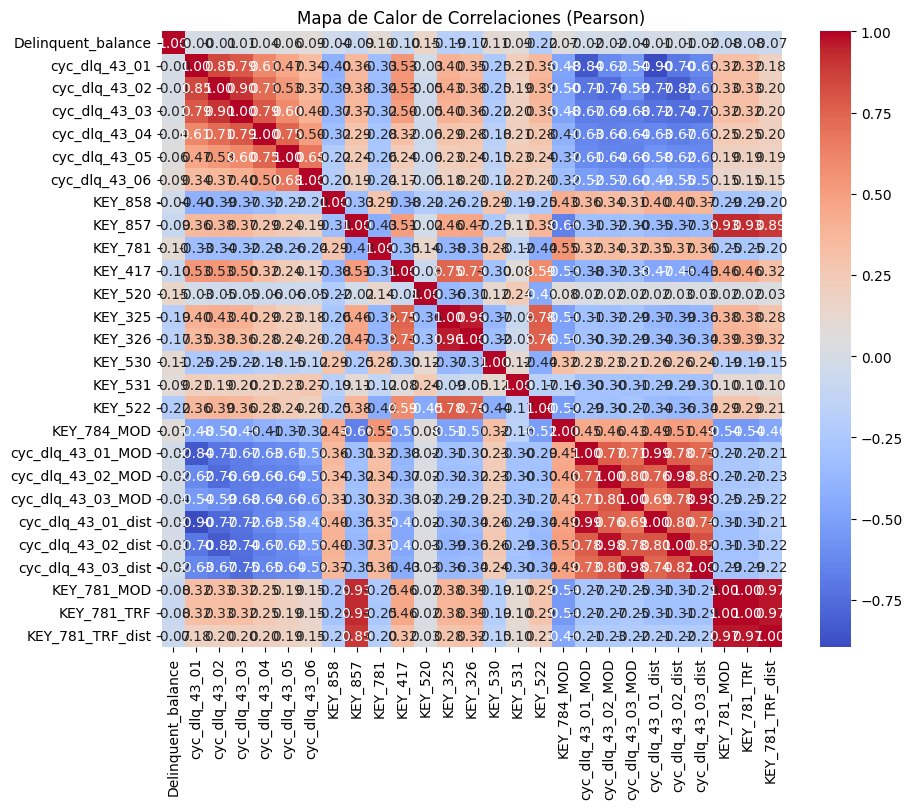

In [17]:
%matplotlib inline

listas_variables = informacion_general(datos_cobranza, umbral_categoricas=5)
resultados_relaciones = relaciones_entre_variables(datos_cobranza, listas_variables, max_categorias=10)

#################################################################################
#NO ME APARECE EL GRAFICO DE CORRELACIONES, PERO CREO QUE EL PROBLEMA PUEDE SER PROVOCADO POR EL USO DEL PROFILING NE MI PC

In [18]:
print("Relaciones Lineales (Pearson):")
print(resultados_relaciones["relaciones_lineales"])

print("\nRelaciones No Lineales (Spearman):")
print(resultados_relaciones["relaciones_no_lineales"])

print("\nRelaciones con Variables Categóricas (Eta Squared):")
print(resultados_relaciones["relaciones_categoricas"])

Relaciones Lineales (Pearson):
[{'variables': ('KEY_781_MOD', 'KEY_781_TRF'), 'correlacion': 0.9999998658477184}, {'variables': ('cyc_dlq_43_01_MOD', 'cyc_dlq_43_01_dist'), 'correlacion': 0.9851457669623042}, {'variables': ('cyc_dlq_43_02_MOD', 'cyc_dlq_43_02_dist'), 'correlacion': 0.9827799058954115}]

Relaciones No Lineales (Spearman):
[{'variables': ('KEY_781_MOD', 'KEY_781_TRF'), 'correlacion': 0.9999999999999999}, {'variables': ('cyc_dlq_43_02_MOD', 'cyc_dlq_43_02_dist'), 'correlacion': 0.9580810929405815}, {'variables': ('cyc_dlq_43_03_MOD', 'cyc_dlq_43_03_dist'), 'correlacion': 0.9445060578068785}]

Relaciones con Variables Categóricas (Eta Squared):
[]


In [20]:
print(datos_cobranza.shape)

#Elimina variables con correlación de Pearson mayor a 0.8 o menor a -0.8
df_red, columnas_eliminadas = eliminar_correlaciones(datos_cobranza, limite=0.8, method='pearson')
print(columnas_eliminadas)

df_pear=df_red

print(df_pear.shape)

(6385, 31)
['cyc_dlq_43_02', 'cyc_dlq_43_03', 'KEY_326', 'CPD_MOD', 'cyc_dlq_43_01_MOD', 'cyc_dlq_43_01_dist', 'cyc_dlq_43_02_dist', 'cyc_dlq_43_03_dist', 'KEY_781_MOD', 'KEY_781_TRF', 'KEY_781_TRF_dist']
(6385, 20)


In [21]:
print(df_pear.shape)
#Elimina variables con correlación de Spearman mayor a 0.8 o menor a -0.8
df_red, columnas_eliminadas = eliminar_correlaciones(df_pear, limite=0.8, method='spearman')
print(columnas_eliminadas)

df_sp=df_red

print(df_sp.shape)

(6385, 20)
['KEY_522', 'cyc_dlq_43_03_MOD']
(6385, 18)


In [22]:
print(df_sp.shape)

#Elimina variables con correlación de Kendall mayor a 0.8 o menor a -0.8
df_red, columnas_eliminadas = eliminar_correlaciones(df_sp, limite=0.8, method='kendall')
print(columnas_eliminadas)

df_clean=df_red

print(df_clean.shape)

(6385, 18)
[]
(6385, 18)


In [23]:
print(datos_cobranza.shape)
print(df_clean.shape)

(6385, 31)
(6385, 18)


# APLICACIÓN DE K-MEANS

Calculando el Método del Codo...


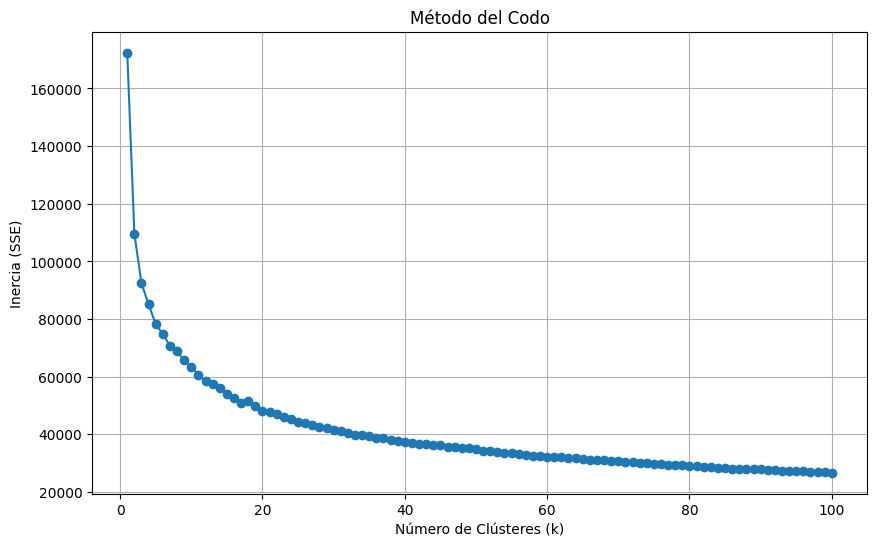

El número óptimo de clústeres según el Método del Codo es: 18
Calculando el Método de la Silueta...


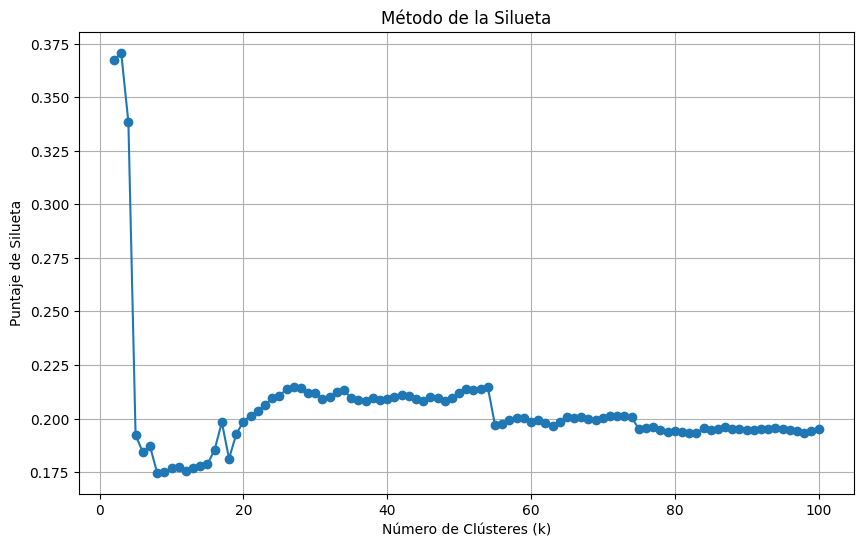

El número óptimo de clústeres según el Método de la Silueta es: 3
Calculando el Método de Gap Statistic...
El número óptimo de clústeres según el Método de Gap Statistic es: 97

Resumen:
- Método del Codo: 18
- Método de la Silueta: 3
- Gap Statistic: 97


In [24]:
data = datos_cobranza[listas_variables["numericas"]]

#Normalizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Rango de k
k_range = range(1, 101)

# 1. Método del Codo
print("Calculando el Método del Codo...")
inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Graficar el Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

# Determinar el mejor k según el Método del Codo
codo_optimo = np.diff(inertia, 2).argmin() + 2
print(f"El número óptimo de clústeres según el Método del Codo es: {codo_optimo}")

# 2. Método de la Silueta
print("Calculando el Método de la Silueta...")
silhouette_scores = []
for k in k_range[1:]:  # Silueta no se define para k=1
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Graficar el Método de la Silueta
plt.figure(figsize=(10, 6))
plt.plot(k_range[1:], silhouette_scores, marker='o')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Puntaje de Silueta')
plt.title('Método de la Silueta')
plt.grid(True)
plt.show()

# Determinar el mejor k según el Método de la Silueta
silueta_optima = np.argmax(silhouette_scores) + 2
print(f"El número óptimo de clústeres según el Método de la Silueta es: {silueta_optima}")

# 3. Gap Statistic
print("Calculando el Método de Gap Statistic...")
optimalK = OptimalK(parallel_backend='joblib')  # Asegúrate de tener instalada la librería 'gap-statistic'
best_k_gap = optimalK(data_scaled, cluster_array=np.arange(1, 101))
print(f"El número óptimo de clústeres según el Método de Gap Statistic es: {best_k_gap}")

# Resultado Final
print("\nResumen:")
print(f"- Método del Codo: {codo_optimo}")
print(f"- Método de la Silueta: {silueta_optima}")
print(f"- Gap Statistic: {best_k_gap}")

In [25]:
# Repetir K-Means 50 veces con k = 3 para obtener el mejor resultado
k = 3
n_repeats = 50
best_model = None
lowest_inertia = float('inf')

print(f"Ejecutando K-Means {n_repeats} veces para seleccionar el mejor resultado...")
for i in range(n_repeats):
    kmeans = KMeans(n_clusters=k, n_init=1, random_state=i)  # Cambiar la semilla en cada iteración
    kmeans.fit(data_scaled)
    if kmeans.inertia_ < lowest_inertia:
        lowest_inertia = kmeans.inertia_
        best_model = kmeans

# Mejor modelo
labels = best_model.labels_

# Agregar etiquetas al DataFrame original
datos_cobranza['Cluster'] = labels

# Centroides del mejor modelo
centroids = best_model.cluster_centers_

print("\nResultados del Mejor K-Means:")
print(f"- Número de clústeres: {k}")
print(f"- Menor inercia (SSE): {lowest_inertia}")
print(f"- Etiquetas asignadas: {np.unique(labels)}")

# Centroides
centroids_df = pd.DataFrame(scaler.inverse_transform(centroids), columns=data.columns)
print("\nCentroides de los clústeres:")
print(centroids_df)

Ejecutando K-Means 50 veces para seleccionar el mejor resultado...

Resultados del Mejor K-Means:
- Número de clústeres: 3
- Menor inercia (SSE): 92421.46464964312
- Etiquetas asignadas: [0 1 2]

Centroides de los clústeres:
   Delinquent_balance  cyc_dlq_43_01  cyc_dlq_43_02  cyc_dlq_43_03  \
0        11049.400547       2.758212       3.496807       3.859033   
1        10744.551278       0.076988       0.030908       0.017983   
2         7797.921136       2.375394       2.976341       3.264984   

   cyc_dlq_43_04  cyc_dlq_43_05  cyc_dlq_43_06   KEY_858   KEY_857    KEY_781  \
0       3.574818       3.211223       2.622719  2.980383  1.745894  13.525547   
1       0.035403       0.059848       0.112672  4.463613  0.715650  49.984546   
2       2.731861       2.205047       1.698738  2.550473  7.564669   9.971609   

   ...  KEY_784_MOD  cyc_dlq_43_01_MOD  cyc_dlq_43_02_MOD  cyc_dlq_43_03_MOD  \
0  ...   715.951186           0.322332           0.321243           0.372533   
1  ...   

Aplicando PCA para K-Means...


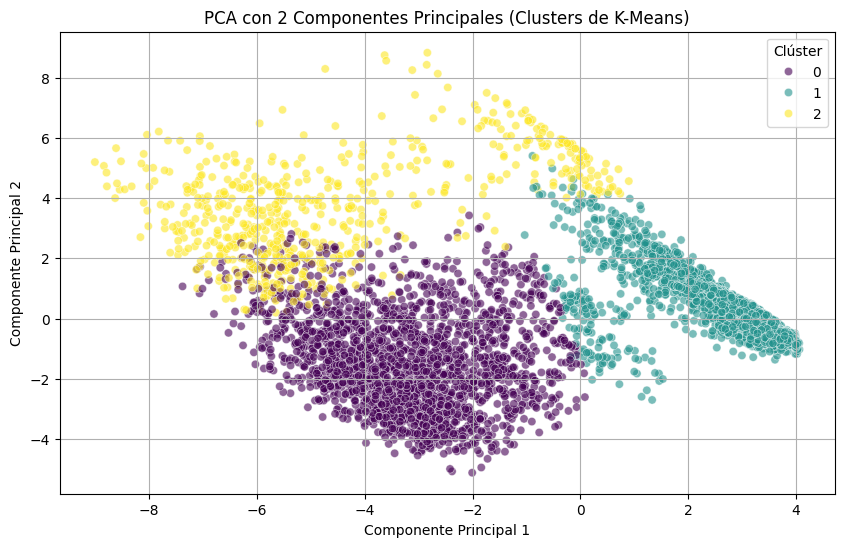

In [26]:
# Aplicar PCA para reducir a 2 componentes principales
print("Aplicando PCA para K-Means...")
pca = PCA(n_components=2)
data_pca_kmeans = pca.fit_transform(data_scaled)

# Crear un DataFrame con las componentes principales y las etiquetas de K-Means
pca_kmeans_df = pd.DataFrame(data_pca_kmeans, columns=['Componente_1', 'Componente_2'])
pca_kmeans_df['Cluster'] = labels  # Etiquetas de K-Means

# Visualización de las dos primeras componentes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Componente_1',
    y='Componente_2',
    hue='Cluster',
    palette='viridis',
    data=pca_kmeans_df,
    alpha=0.6
)
plt.title("PCA con 2 Componentes Principales (Clusters de K-Means)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Clúster", loc='best')
plt.grid(True)
plt.show()

C:\Users\Pau\AppData\Local\Temp\ipykernel_21068\897395460.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Clúster", loc='best')


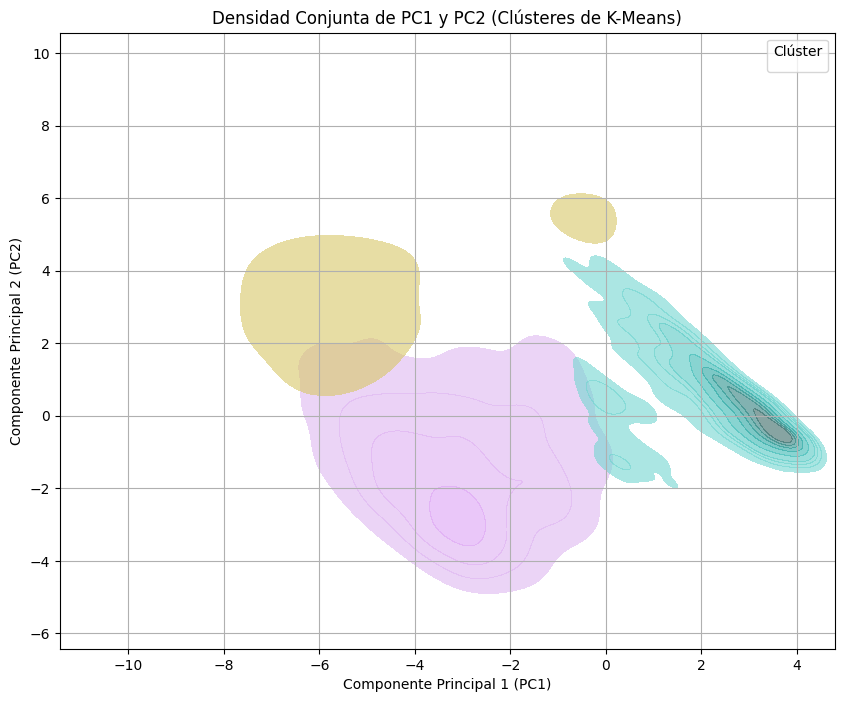

In [27]:
# Gráfico de densidad conjunta para PC1 y PC2 coloreado por Clúster
plt.figure(figsize=(10, 8))
sns.kdeplot(
    x=pca_kmeans_df['Componente_1'], 
    y=pca_kmeans_df['Componente_2'], 
    hue=pca_kmeans_df['Cluster'], 
    fill=True, 
    palette='viridis', 
    alpha=0.6
)
plt.title("Densidad Conjunta de PC1 y PC2 (Clústeres de K-Means)")
plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.grid(True)
plt.legend(title="Clúster", loc='best')
plt.show()

In [28]:
import skfuzzy as fuzzy
# Aplicar Fuzzy C-Means con skfuzzy
print("Aplicando Fuzzy C-Means...")

# Transponer los datos escalados para ajustarse al formato esperado por skfuzzy
data_t = data_scaled.T  # skfuzzy requiere variables como columnas

# Configurar y ejecutar Fuzzy C-Means
n_clusters = 3  # Número de clústeres
cntr, u, u0, d, jm, p, fpc = fuzzy.cmeans(
    data_t, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None
)

# Obtener etiquetas de clúster basadas en la mayor pertenencia
fuzzy_labels = np.argmax(u, axis=0)
# Calcular Silhouette Score para Fuzzy C-Means
fuzzy_silhouette = silhouette_score(data_scaled, fuzzy_labels)

print("\nResultados de Fuzzy C-Means:")
print(f"- Coeficiente de Partición (FPC): {fpc:.2f}")
print(f"- Silhouette Score: {fuzzy_silhouette:.2f}")

Aplicando Fuzzy C-Means...

Resultados de Fuzzy C-Means:
- Coeficiente de Partición (FPC): 0.48
- Silhouette Score: 0.29


# PERFILAMIENTO CON ARBOLES DE DECISIÓN